1. Installation and setup of pyspark

In [1]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [51.0 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,037 kB]
Get:13 https://developer.download.nvidia

In [2]:
!pip install pyspark==3.1.1 #--default version is 3.5.1, but to make this work we must match the spark and pyspark version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 9.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767581 sha256=434ace510a4c9735b001dad01fbf05519d89d3c5d2c34ddf255b6147559787ff
  Stored in directory: /root/.cache/pip/wheels/a0/3f/72/8efd988f9ae041f051c75e6834cd92dd6d13a726e206e8b6f3
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()

In [4]:
!ls

sample_data  spark-3.1.1-bin-hadoop3.2	spark-3.1.1-bin-hadoop3.2.tgz


In [5]:
# Importing packages
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

Visualization Options

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

2. Creating the spark session

In [8]:
spark = SparkSession.builder.master("local[2]").appName("Linear Regression model of Housing prediction").getOrCreate()

In [9]:
spark

In [10]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear Regression model of Housing prediction>

In [11]:
sqlContext = SQLContext(sc)
sqlContext

3. Loading data from the datafile into a DataFrame

In [12]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
HOUSING_DATA='/content/drive/MyDrive/Colab Notebooks/bfsi_models_practice/house price with pyspark/cal_housing.data'
# defining the schema
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Loading the file and reading the first 5 rows
housing_df = spark.read.csv(path=HOUSING_DATA, schema=schema).cache()
housing_df.take(5)
housing_df.show(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



**Longitude**:refers to the angular distance of a geographic place north or south of the earth’s equator for each block group

**Latitude** :refers to the angular distance of a geographic place east or west of the earth’s equator for each block group

**Housing Median Age**:is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values

**Total Rooms**:is the total number of rooms in the houses per block group

**Total Bedrooms**:is the total number of bedrooms in the houses per block group

**Population**:is the number of inhabitants of a block group

**Households**:refers to units of houses and their occupants per block group

**Median Income**:is used to register the median income of people that belong to a block group

**Median House Value**:is the dependent variable and refers to the median house value per block group


In [14]:
# Schema of the DataFrame
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



4. Data Exploration

In [15]:
# Looking at a population and total bedrooms sample of 10 records
housing_df.createOrReplaceTempView('houses')
qry = "select pop, totbdrms from houses limit 10"
spark.sql(qry).show()

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+



Distribution of median age of people living in the houses

In [16]:
qry = "select medage, count(medage) from houses group by medage order by medage desc limit 10"
spark.sql(qry).show()

+------+-------------+
|medage|count(medage)|
+------+-------------+
|  52.0|         1273|
|  51.0|           48|
|  50.0|          136|
|  49.0|          134|
|  48.0|          177|
|  47.0|          198|
|  46.0|          245|
|  45.0|          294|
|  44.0|          356|
|  43.0|          353|
+------+-------------+



Visualization of this distribution

<Axes: xlabel='medage'>

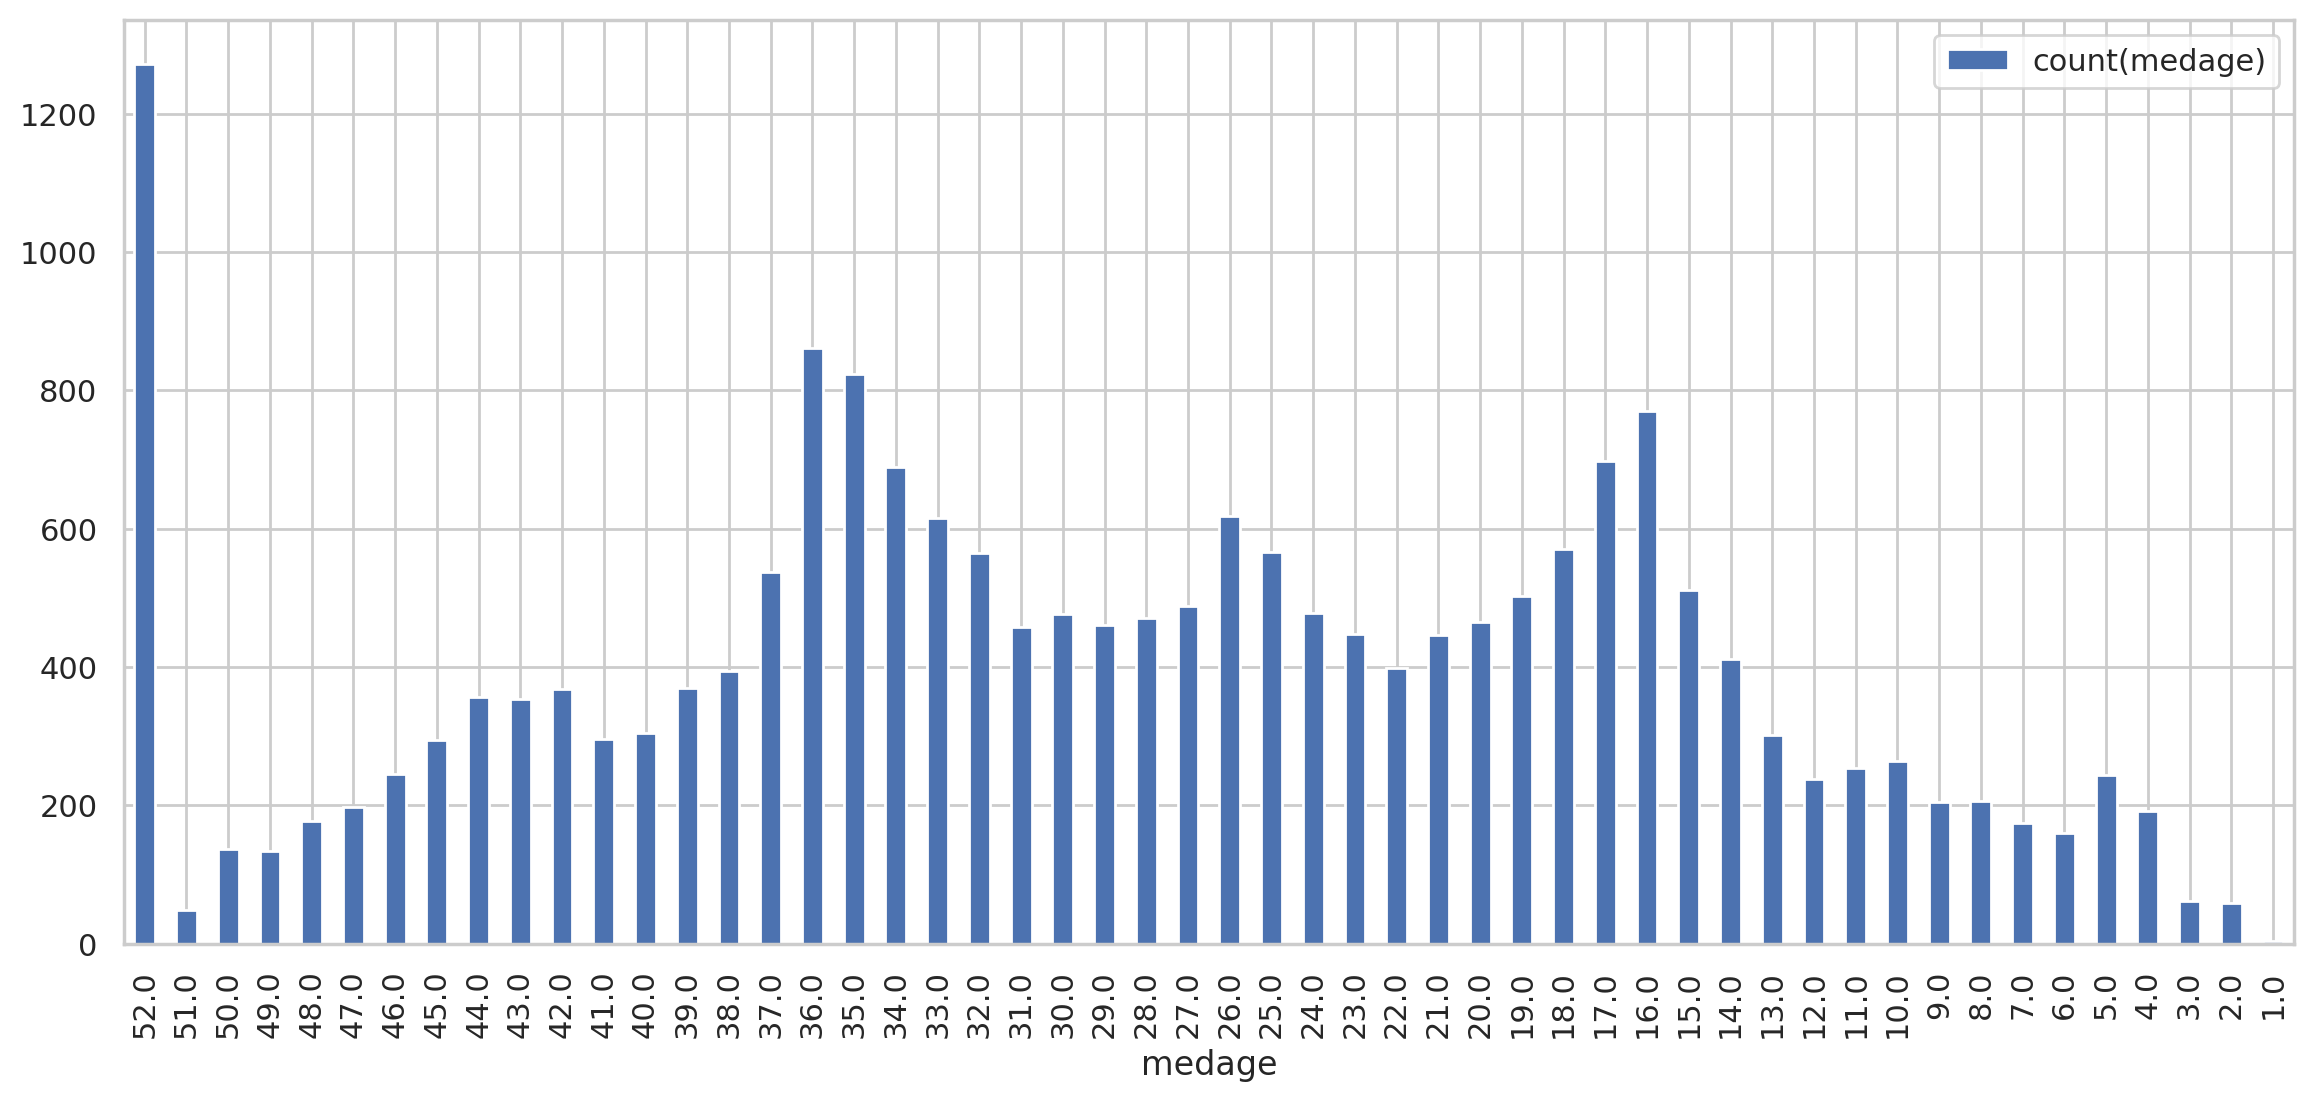

In [17]:
qry = "select medage, count(medage) from houses group by medage order by medage desc"
result_df = sqlContext.sql(qry)
result_df.toPandas().plot.bar(x = 'medage', figsize = (14,6))

Most of the residents are in their youth or in their senior years. Some median ages are below 10. These seems to be outliers.

In [18]:
# Looking at the distribution of all columns
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



Many columns have a very wide spread between min and mx values. Normalization is required

5. Data Preprocessig

In [19]:
# Columns in the dataframe
housing_df.columns
housing_df.show(2)  #--The dependent / target variable is medhv or median house value


['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 2 rows



In [20]:
# To scale the medhv, we divide by 100000
housing_df = housing_df.withColumn('medhv', col('medhv')/100000)
housing_df.show(2) # Data distribution looks better after scaling

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



6. Feature Engineering

In [21]:
# Adding 3 new columns, namely rooms per household (rmsperhh), population per household (popperhh) and bedrooms per rooms ration (bedrmsperrm)
housing_df = (housing_df.withColumn('rmsperhh', F.round(col('totrooms')/col('houshlds'), 2))
                       .withColumn('popperhh', F.round(col('pop')/col('houshlds'), 2))
                       .withColumn('bedrmsperrm', F.round(col('totbdrms')/col('totrooms'), 2)))
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+-----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bedrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+-----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|       0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|       0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|       0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|       0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|       0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+-----------+
only showing top 5 rows



The first row shows 2.56 people living in a 6.98 rooms household, where only 0.15 of the rooms are bedrooms. These kind of records seem to be outliers.

Some columns like long, lat, median age of houses and total rooms are not required any more so skipping them from further processing.


In [22]:
# Re-ordering and selection of columns
'''
housing_df = housing_df.select("medhv",
                              "totbdrms",
                              "pop",
                              "houshlds",
                              "medinc",
                              "rmsperhh",
                              "popperhh",
                              "bedrmsperrm")
'''
housing_df.createOrReplaceTempView('houses')
qry = 'select medhv, totbdrms, pop, houshlds, medinc, rmsperhh, popperhh, bedrmsperrm from houses'
housing_df = sqlContext.sql(qry)
housing_df.show(5)

'\nhousing_df = housing_df.select("medhv",\n                              "totbdrms",\n                              "pop",\n                              "houshlds",\n                              "medinc",\n                              "rmsperhh",\n                              "popperhh",\n                              "bedrmsperrm")\n'

+-----+--------+------+--------+------+--------+--------+-----------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bedrmsperrm|
+-----+--------+------+--------+------+--------+--------+-----------+
|4.526|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|       0.15|
|3.585|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|       0.16|
|3.521|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|       0.13|
|3.413|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|       0.18|
|3.422|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|       0.17|
+-----+--------+------+--------+------+--------+--------+-----------+
only showing top 5 rows



Feature extraction and standardization

In [23]:
# Using Vector Assembler to combine the feature columns
featureCols = ["totbdrms","pop","houshlds","medinc","rmsperhh","popperhh","bedrmsperrm"]
assembler = VectorAssembler(inputCols = featureCols, outputCol = "features")
assembled_df = assembler.transform(housing_df)
assembled_df.show(10, truncate = False)

+-----+--------+------+--------+------+--------+--------+-----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bedrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+-----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15       |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16       |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13       |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18       |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17       |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0

In [24]:
# Using StandardScaler to scale the combined vector, features
sc = StandardScaler(inputCol = "features", outputCol = "features_scaled") #--initialization of the standard scaler
scaled_df = sc.fit(assembled_df).transform(assembled_df) #--fitting the DataFrame into the scaler
scaled_df.select("features", "features_scaled").show(5, truncate = False) #--reviewing the outcome

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

7. Model building with spark ML

In [25]:
# Train and Test split
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed = rnd_seed)
train_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bedrmsperrm',
 'features',
 'features_scaled']

In [26]:
# Elastic net model since multiple features are correlated
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))
linearModel = lr.fit(train_data) #--training the model

8. Model Evaluation

In [27]:
# Inspection of the coefficients
print("linearModel coeffs :\n",linearModel.coefficients)
print("featureCols :\n",featureCols)
print("linearModel intercept :\n",linearModel.intercept)

linearModel coeffs :
 [0.0,0.0,0.0,0.5261572529207581,0.0,0.0,0.0]
featureCols :
 ['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bedrmsperrm']
linearModel intercept :
 1.0013833516596085


In [28]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]
coeff_df

,Feature,Co-efficients
0,Intercept,1.001383
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.526157
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bedrmsperrm,0.000000


Generating predictions

In [29]:
predictions = linearModel.transform(test_data)
# Extracting the predictions against test data labels
pred_and_labels = predictions.select('predmedhv', 'medhv')
pred_and_labels.show(5)

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
|  1.14982901467337|0.14999|
|1.3037582901805782|  0.225|
| 1.752972574315186|  0.225|
|1.6094289295308724|  0.269|
|1.5956645319495768|  0.344|
+------------------+-------+
only showing top 5 rows



9. Metrics inspections

In [30]:
# Using linear regression summary attribute
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError)) #-- Root Mean Squared Error
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError)) #-- Mean Absolute Error
print("R Squared value: {0}".format(linearModel.summary.r2)) #--Coefficient of determination

RMSE: 0.8819852045268861
MAE: 0.6782895319917991
R Squared value: 0.4180854895364573


In [31]:
# Using RegressionEvaluator from the pyspark.ml package
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R Squared value: {0}".format(evaluator.evaluate(pred_and_labels)))

RMSE: 0.8677342923034236
MAE: 0.6736097745764633
R Squared value: 0.42517112885139363


10. Summary : Even though the above 2 sets of metrics closely match, the error values are quite high while the R Squared values are less than 0.5. The model definitely needs more refinement for better results.